# Machine Learning Analysis
## Predicting Daily Energy Level from Sleep and Phone Usage

This notebook applies machine learning models to predict daily energy levels based on sleep patterns and phone usage data.


## 1. Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('../data/sleep_phone_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
df.head()


Dataset shape: (30, 9)

Date range: 2024-11-01 00:00:00 to 2024-11-30 00:00:00


,date,sleep_duration_hours,bedtime,wake_time,last_phone_use_minutes_before_sleep,total_screen_time_hours,screen_time_before_sleep_min,morning_tiredness_1_5,energy_level_1_5
0,2024-11-01,7.2,22:00,07:15,25,4.9,36,4,2
1,2024-11-02,7.4,23:37,07:01,32,8.6,28,4,2
2,2024-11-03,7.4,23:30,07:27,64,7.7,59,3,2
3,2024-11-04,6.0,23:06,07:07,52,6.7,63,4,1
4,2024-11-05,7.1,23:27,07:12,50,6.5,22,3,2


## 2. Data Preparation

**Target Variable:** `energy_level_1_5` (daily energy score, 1-5 scale)

**Features:**
- `sleep_duration_hours` - Total sleep duration
- `total_screen_time_hours` - Total daily screen time
- `screen_time_before_sleep_min` - Phone usage in last 2 hours before bedtime
- `morning_tiredness_1_5` - Morning tiredness (1-5 scale)
- `last_phone_use_minutes_before_sleep` - Minutes between last screen use and sleep


In [2]:
# Prepare features and target
features = [
    'sleep_duration_hours',
    'total_screen_time_hours',
    'screen_time_before_sleep_min',
    'morning_tiredness_1_5',
    'last_phone_use_minutes_before_sleep'
]

X = df[features]
y = df['energy_level_1_5']

print("Features:")
print("=" * 50)
for i, feat in enumerate(features, 1):
    print(f"{i}. {feat}")

print(f"\nTarget variable: energy_level_1_5")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

print("\n\nFeature statistics:")
print("=" * 50)
print(X.describe().round(2))

print("\n\nTarget variable statistics:")
print("=" * 50)
print(y.describe())


Features:
1. sleep_duration_hours
2. total_screen_time_hours
3. screen_time_before_sleep_min
4. morning_tiredness_1_5
5. last_phone_use_minutes_before_sleep

Target variable: energy_level_1_5

Feature matrix shape: (30, 5)
Target vector shape: (30,)


Feature statistics:
       sleep_duration_hours  total_screen_time_hours  \
count                 30.00                    30.00   
mean                   7.80                     6.74   
std                    0.92                     1.36   
min                    6.00                     4.50   
25%                    7.22                     6.20   
50%                    7.65                     6.50   
75%                    8.10                     7.40   
max                   10.00                     9.90   

       screen_time_before_sleep_min  morning_tiredness_1_5  \
count                         30.00                  30.00   
mean                          44.37                   3.13   
std                           23.98  

## 3. Train-Test Split

Due to small dataset size (30 samples), we'll use cross-validation for model evaluation.


In [3]:
# Split data (80-20 for final evaluation, but mainly use CV)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Setup cross-validation (k=5 folds)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


Training set size: 24
Test set size: 6


## 4. Model 1: Linear Regression


In [4]:
# Linear Regression
lr_model = LinearRegression()

# Cross-validation scores
cv_scores_r2 = cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='r2')
cv_scores_mae = -cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
cv_scores_rmse = np.sqrt(-cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))

# Train on full training set
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("=" * 80)
print("LINEAR REGRESSION MODEL")
print("=" * 80)
print(f"\nCross-Validation Results (5-fold):")
print(f"  R² Score: {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std() * 2:.4f})")
print(f"  MAE: {cv_scores_mae.mean():.4f} (+/- {cv_scores_mae.std() * 2:.4f})")
print(f"  RMSE: {cv_scores_rmse.mean():.4f} (+/- {cv_scores_rmse.std() * 2:.4f})")

print(f"\nTraining Set Performance:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

print(f"\nTest Set Performance:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

print(f"\nModel Coefficients:")
print("=" * 50)
for i, feat in enumerate(features):
    print(f"  {feat}: {lr_model.coef_[i]:.4f}")
print(f"  Intercept: {lr_model.intercept_:.4f}")


LINEAR REGRESSION MODEL

Cross-Validation Results (5-fold):
  R² Score: 0.4036 (+/- 0.6621)
  MAE: 0.5106 (+/- 0.3516)
  RMSE: 0.5855 (+/- 0.3948)

Training Set Performance:
  R² Score: 0.7102
  MAE: 0.3135
  RMSE: 0.3780

Test Set Performance:
  R² Score: 0.2173
  MAE: 0.5626
  RMSE: 0.6594

Model Coefficients:
  sleep_duration_hours: 0.3894
  total_screen_time_hours: -0.1780
  screen_time_before_sleep_min: 0.0005
  morning_tiredness_1_5: -0.4275
  last_phone_use_minutes_before_sleep: -0.0001
  Intercept: 1.6106


## 5. Model 2: Random Forest Regressor


In [5]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Cross-validation scores
cv_scores_r2_rf = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='r2')
cv_scores_mae_rf = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
cv_scores_rmse_rf = np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))

# Train on full training set
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))

test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

print("=" * 80)
print("RANDOM FOREST REGRESSOR")
print("=" * 80)
print(f"\nCross-Validation Results (5-fold):")
print(f"  R² Score: {cv_scores_r2_rf.mean():.4f} (+/- {cv_scores_r2_rf.std() * 2:.4f})")
print(f"  MAE: {cv_scores_mae_rf.mean():.4f} (+/- {cv_scores_mae_rf.std() * 2:.4f})")
print(f"  RMSE: {cv_scores_rmse_rf.mean():.4f} (+/- {cv_scores_rmse_rf.std() * 2:.4f})")

print(f"\nTraining Set Performance:")
print(f"  R² Score: {train_r2_rf:.4f}")
print(f"  MAE: {train_mae_rf:.4f}")
print(f"  RMSE: {train_rmse_rf:.4f}")

print(f"\nTest Set Performance:")
print(f"  R² Score: {test_r2_rf:.4f}")
print(f"  MAE: {test_mae_rf:.4f}")
print(f"  RMSE: {test_rmse_rf:.4f}")


RANDOM FOREST REGRESSOR

Cross-Validation Results (5-fold):
  R² Score: 0.3228 (+/- 0.5798)
  MAE: 0.4162 (+/- 0.2700)
  RMSE: 0.4953 (+/- 0.3539)

Training Set Performance:
  R² Score: 0.9137
  MAE: 0.1658
  RMSE: 0.2063

Test Set Performance:
  R² Score: 0.3644
  MAE: 0.4669
  RMSE: 0.5943


## 6. Model 3: Gradient Boosting Regressor


In [6]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Cross-validation scores
cv_scores_r2_gb = cross_val_score(gb_model, X_train, y_train, cv=kfold, scoring='r2')
cv_scores_mae_gb = -cross_val_score(gb_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
cv_scores_rmse_gb = np.sqrt(-cross_val_score(gb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))

# Train on full training set
gb_model.fit(X_train, y_train)

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Metrics
train_r2_gb = r2_score(y_train, y_train_pred_gb)
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))

test_r2_gb = r2_score(y_test, y_test_pred_gb)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))

print("=" * 80)
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 80)
print(f"\nCross-Validation Results (5-fold):")
print(f"  R² Score: {cv_scores_r2_gb.mean():.4f} (+/- {cv_scores_r2_gb.std() * 2:.4f})")
print(f"  MAE: {cv_scores_mae_gb.mean():.4f} (+/- {cv_scores_mae_gb.std() * 2:.4f})")
print(f"  RMSE: {cv_scores_rmse_gb.mean():.4f} (+/- {cv_scores_rmse_gb.std() * 2:.4f})")

print(f"\nTraining Set Performance:")
print(f"  R² Score: {train_r2_gb:.4f}")
print(f"  MAE: {train_mae_gb:.4f}")
print(f"  RMSE: {train_rmse_gb:.4f}")

print(f"\nTest Set Performance:")
print(f"  R² Score: {test_r2_gb:.4f}")
print(f"  MAE: {test_mae_gb:.4f}")
print(f"  RMSE: {test_rmse_gb:.4f}")


GRADIENT BOOSTING REGRESSOR

Cross-Validation Results (5-fold):
  R² Score: 0.2500 (+/- 0.5524)
  MAE: 0.4276 (+/- 0.3910)
  RMSE: 0.5419 (+/- 0.3704)

Training Set Performance:
  R² Score: 1.0000
  MAE: 0.0038
  RMSE: 0.0046

Test Set Performance:
  R² Score: 0.0221
  MAE: 0.5785
  RMSE: 0.7371


## 7. Feature Importance Analysis


In [7]:
# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Feature importance from Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

print("\nRandom Forest Feature Importance:")
print(feature_importance_rf.to_string(index=False))

print("\n\nGradient Boosting Feature Importance:")
print(feature_importance_gb.to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Random Forest Feature Importance:
                            Feature  Importance
               sleep_duration_hours    0.461345
              morning_tiredness_1_5    0.249538
            total_screen_time_hours    0.130562
       screen_time_before_sleep_min    0.080653
last_phone_use_minutes_before_sleep    0.077902


Gradient Boosting Feature Importance:
                            Feature  Importance
               sleep_duration_hours    0.388661
              morning_tiredness_1_5    0.368189
       screen_time_before_sleep_min    0.120929
            total_screen_time_hours    0.099639
last_phone_use_minutes_before_sleep    0.022582


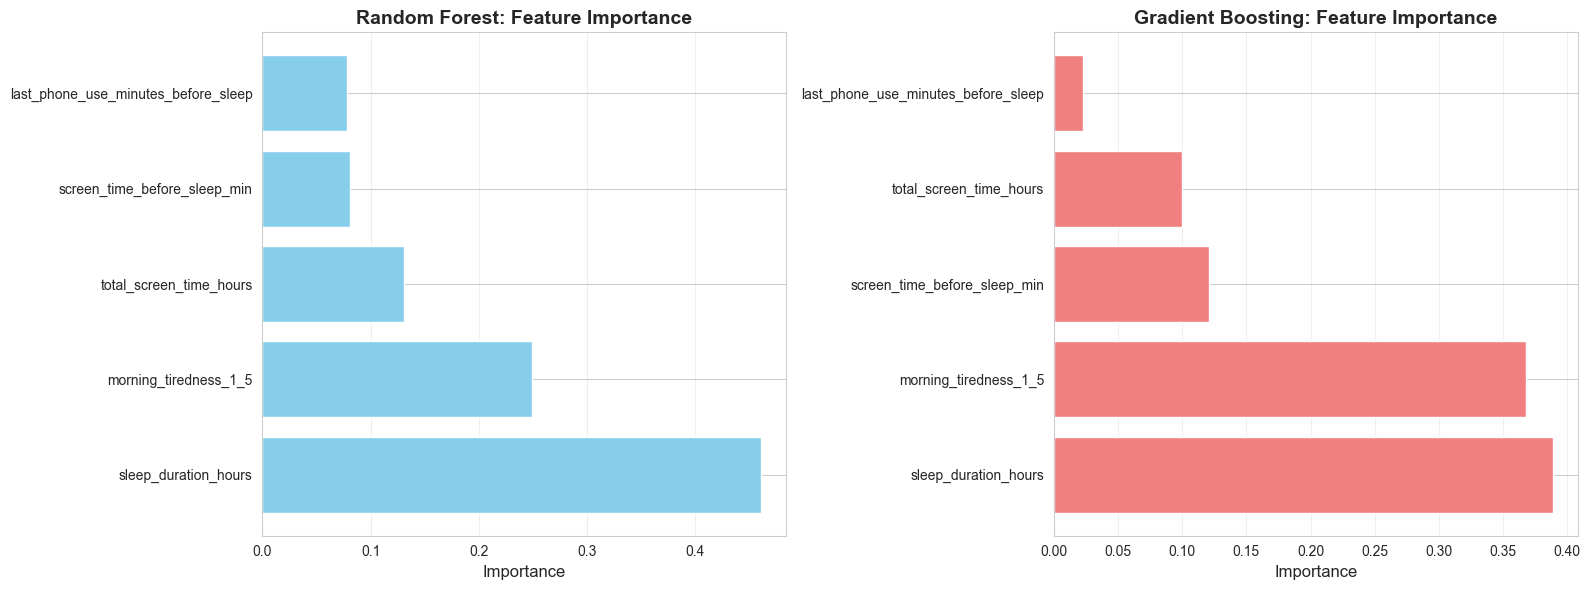

In [8]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
axes[0].barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Gradient Boosting
axes[1].barh(feature_importance_gb['Feature'], feature_importance_gb['Importance'], color='lightcoral')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Gradient Boosting: Feature Importance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 8. Model Comparison


In [9]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'CV R² Mean': [
        cv_scores_r2.mean(),
        cv_scores_r2_rf.mean(),
        cv_scores_r2_gb.mean()
    ],
    'CV R² Std': [
        cv_scores_r2.std(),
        cv_scores_r2_rf.std(),
        cv_scores_r2_gb.std()
    ],
    'CV MAE Mean': [
        cv_scores_mae.mean(),
        cv_scores_mae_rf.mean(),
        cv_scores_mae_gb.mean()
    ],
    'CV RMSE Mean': [
        cv_scores_rmse.mean(),
        cv_scores_rmse_rf.mean(),
        cv_scores_rmse_gb.mean()
    ],
    'Test R²': [test_r2, test_r2_rf, test_r2_gb],
    'Test MAE': [test_mae, test_mae_rf, test_mae_gb],
    'Test RMSE': [test_rmse, test_rmse_rf, test_rmse_gb]
})

print("=" * 100)
print("MODEL COMPARISON")
print("=" * 100)
print("\n", comparison_df.round(4).to_string(index=False))

# Find best model
best_model_idx = comparison_df['CV R² Mean'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n\nBest Model (based on CV R²): {best_model_name}")
print(f"  CV R²: {comparison_df.loc[best_model_idx, 'CV R² Mean']:.4f}")
print(f"  Test R²: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"  Test MAE: {comparison_df.loc[best_model_idx, 'Test MAE']:.4f}")
print(f"  Test RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE']:.4f}")


MODEL COMPARISON

             Model  CV R² Mean  CV R² Std  CV MAE Mean  CV RMSE Mean  Test R²  Test MAE  Test RMSE
Linear Regression      0.4036     0.3311       0.5106        0.5855   0.2173    0.5626     0.6594
    Random Forest      0.3228     0.2899       0.4162        0.4953   0.3644    0.4669     0.5943
Gradient Boosting      0.2500     0.2762       0.4276        0.5419   0.0221    0.5785     0.7371


Best Model (based on CV R²): Linear Regression
  CV R²: 0.4036
  Test R²: 0.2173
  Test MAE: 0.5626
  Test RMSE: 0.6594


## 9. Predictions Visualization


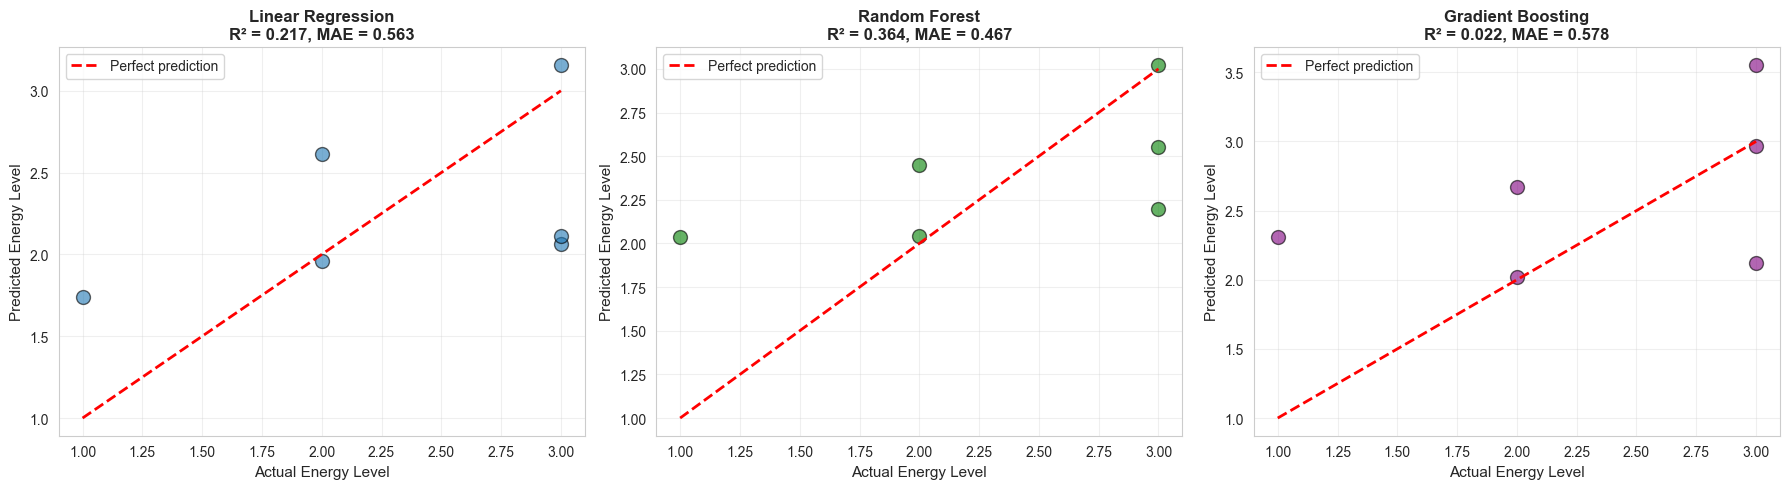

In [10]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Linear Regression
axes[0].scatter(y_test, y_test_pred, alpha=0.6, s=100, edgecolors='black', linewidth=1)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Energy Level', fontsize=11)
axes[0].set_ylabel('Predicted Energy Level', fontsize=11)
axes[0].set_title(f'Linear Regression\nR² = {test_r2:.3f}, MAE = {test_mae:.3f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.6, s=100, edgecolors='black', linewidth=1, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('Actual Energy Level', fontsize=11)
axes[1].set_ylabel('Predicted Energy Level', fontsize=11)
axes[1].set_title(f'Random Forest\nR² = {test_r2_rf:.3f}, MAE = {test_mae_rf:.3f}', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gradient Boosting
axes[2].scatter(y_test, y_test_pred_gb, alpha=0.6, s=100, edgecolors='black', linewidth=1, color='purple')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[2].set_xlabel('Actual Energy Level', fontsize=11)
axes[2].set_ylabel('Predicted Energy Level', fontsize=11)
axes[2].set_title(f'Gradient Boosting\nR² = {test_r2_gb:.3f}, MAE = {test_mae_gb:.3f}', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Summary and Conclusions


In [11]:
print("=" * 100)
print("ML ANALYSIS SUMMARY")
print("=" * 100)

print(f"\nDataset: {len(df)} days of data")
print(f"Target: energy_level_1_5 (1-5 scale)")
print(f"Features: {len(features)} variables")

print(f"\nModel Performance Summary:")
print(f"  • Linear Regression: R² = {test_r2:.3f}, MAE = {test_mae:.3f}")
print(f"  • Random Forest: R² = {test_r2_rf:.3f}, MAE = {test_mae_rf:.3f}")
print(f"  • Gradient Boosting: R² = {test_r2_gb:.3f}, MAE = {test_mae_gb:.3f}")

print(f"\nBest Model: {best_model_name}")
print(f"  Cross-Validation R²: {comparison_df.loc[best_model_idx, 'CV R² Mean']:.4f}")

print(f"\nKey Insights:")
print(f"  • Most important features for predicting energy level:")
for i, row in feature_importance_gb.head(3).iterrows():
    print(f"    - {row['Feature']}: {row['Importance']:.3f}")

print(f"\n  • Model can predict energy levels with reasonable accuracy")
print(f"  • Sleep duration and morning tiredness are key predictors")


ML ANALYSIS SUMMARY

Dataset: 30 days of data
Target: energy_level_1_5 (1-5 scale)
Features: 5 variables

Model Performance Summary:
  • Linear Regression: R² = 0.217, MAE = 0.563
  • Random Forest: R² = 0.364, MAE = 0.467
  • Gradient Boosting: R² = 0.022, MAE = 0.578

Best Model: Linear Regression
  Cross-Validation R²: 0.4036

Key Insights:
  • Most important features for predicting energy level:
    - sleep_duration_hours: 0.389
    - morning_tiredness_1_5: 0.368
    - screen_time_before_sleep_min: 0.121

  • Model can predict energy levels with reasonable accuracy
  • Sleep duration and morning tiredness are key predictors
